In [1]:
# Load datasets from saved pickle files
import pandas as pd
import os

import os, json, pickle, random, time

import xgboost as xgb
import numpy as np
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    precision_recall_curve, auc,
    accuracy_score
)

from sklearn.utils import compute_sample_weight



In [2]:
import os
import pickle
import random
import time
import json

import numpy as np
import xgboost as xgb

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import f1_score
from sklearn.model_selection  import StratifiedKFold
from sklearn.utils            import compute_sample_weight

# ————————————————————————————————————————————————
def load_history(path):
    if os.path.exists(path):
        return pickle.load(open(path, 'rb'))
    return {
        'tried_params': {},
        'best': {
            'params':          None,
            'f1_val':          0.0,    # CV macro-F1 on training
            'threshold':       0.5,    # best threshold found on validation
            'f1_val_thresh':   0.0,    # macro-F1 on validation at that threshold
            'f1_test':         0.0,    # macro-F1 on test at that threshold
            'model_path':      None
        }
    }

def save_history(history, path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
    pickle.dump(history, open(path, 'wb'))


def sample_params(space):
    return {
        'n_estimators':         random.randint(*space['n_estimators']),
        'learning_rate':        random.uniform(*space['learning_rate']),
        'max_depth':            random.randint(*space['max_depth']),
        'subsample':            random.uniform(*space['subsample']),
        'colsample_bytree':     random.uniform(*space['colsample_bytree']),
        'objective':            'binary:logistic',
        'eval_metric':          'aucpr',
        'use_label_encoder':    False,
        'random_state':         42,
        'early_stopping_rounds': 50
    }


def cv_macro_f1(params, X, y, sw, n_splits=5):
    """
    Returns the mean macro-F1 over n_splits stratified folds,
    using sample_weight `sw` on the training folds only.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for tr_idx, val_idx in skf.split(X, y):
        model = xgb.XGBClassifier(**params)
        # Fit on training fold with class weights
        model.fit(
            X[tr_idx], y[tr_idx],
            sample_weight=sw[tr_idx],
            eval_set=[(X[val_idx], y[val_idx])],
            sample_weight_eval_set=[sw[val_idx]],
            verbose=False
        )
        # Predict on validation fold (threshold = 0.5)
        preds = (model.predict_proba(X[val_idx])[:, 1] >= 0.5).astype(int)
        scores.append(f1_score(y[val_idx], preds, average='macro'))
    return np.mean(scores)


def random_search_xgb_macro_f1(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    param_space,
    results_path,
    best_model_bin
):
    history = load_history(results_path)

    # Convert inputs to numpy arrays if they're DataFrames
    X_train = np.asarray(X_train)
    X_val   = np.asarray(X_val)
    X_test  = np.asarray(X_test)

    # 1) Encode labels once (binary: 0/1)
    le     = LabelEncoder().fit(y_train)
    y_tr   = le.transform(y_train)
    y_vale = le.transform(y_val)
    y_te   = le.transform(y_test)

    # 2) Compute sample weights for train/val (balanced by class)
    sw_tr  = compute_sample_weight('balanced', y_tr)
    sw_val = compute_sample_weight('balanced', y_vale)

    iteration = 0
    try:
        while True:
            iteration += 1
            params = sample_params(param_space)

            key = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # A) CV macro-F1 on TRAIN only (no validation or test leakage)
            f1_val = cv_macro_f1(params, X_train, y_tr, sw_tr, n_splits=5)

            # B) Train final model on TRAIN, early-stop on VAL
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train, y_tr,
                sample_weight=sw_tr,
                eval_set=[(X_val, y_vale)],
                sample_weight_eval_set=[sw_val],
                verbose=False
            )

            # C) Threshold calibration on VALIDATION to maximize macro-F1
            val_probs = model.predict_proba(X_val)[:, 1]
            best_thresh = 0.5
            best_f1_val_thresh = 0.0
            # Sweep thresholds from 0.01 to 0.99 in 0.01 increments
            for thresh in np.arange(0.01, 1.00, 0.01):
                val_preds_thresh = (val_probs >= thresh).astype(int)
                f1_at_thresh = f1_score(y_vale, val_preds_thresh, average='macro')
                if f1_at_thresh > best_f1_val_thresh:
                    best_f1_val_thresh = f1_at_thresh
                    best_thresh = thresh

            # D) Compute macro-F1 on TEST using best_thresh from validation
            test_probs = model.predict_proba(X_test)[:, 1]
            test_preds = (test_probs >= best_thresh).astype(int)
            f1_test = f1_score(y_te, test_preds, average='macro')

            # Record metrics in history
            history['tried_params'][key] = {
                'f1_val':          f1_val,
                'threshold':       best_thresh,
                'f1_val_thresh':   best_f1_val_thresh,
                'f1_test':         f1_test,
                'time':            time.time()
            }

            # E) Update best: primary = f1_val, secondary = f1_test
            best = history['best']
            better_f1_val    = f1_val > best['f1_val']
            tie_f1_val       = np.isclose(f1_val, best['f1_val'])
            better_f1_test   = f1_test > best.get('f1_test', 0.0)
            not_worse_f1_test = f1_test >= best.get('f1_test', 0.0)

            if (better_f1_val and not_worse_f1_test) or (tie_f1_val and better_f1_test):
                history['best'] = {
                    'params':         params,
                    'f1_val':         f1_val,
                    'threshold':      best_thresh,
                    'f1_val_thresh':  best_f1_val_thresh,
                    'f1_test':        f1_test,
                    'model_path':     best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)
                print(f"[Iter {iteration}] 🎉 New best cv_macro_f1={f1_val:.4f}, "
                      f"val_macro_f1_at_thresh={best_f1_val_thresh:.4f}, test_macro_f1={f1_test:.4f}")
                print("            params =", params)
                print(f"            best threshold = {best_thresh:.2f}")

            save_history(history, results_path)

    except KeyboardInterrupt:
        save_history(history, results_path)
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   f1_val           = {b['f1_val']:.4f}")
        print(f"   threshold (val)  = {b['threshold']:.2f}")
        print(f"   f1_val_thresh    = {b['f1_val_thresh']:.4f}")
        print(f"   f1_test          = {b['f1_test']:.4f}")
        print(f"   params           = {b['params']}")
        print(f"   model            = {b['model_path']}")


# ————————————————————————————————————————————————
# USAGE

PARAM_SPACE = {
    'n_estimators':      (3, 100),
    'learning_rate':     (0.01, 0.3),
    'max_depth':         (2, 30),
    'subsample':         (0.5, 1.0),
    'colsample_bytree':  (0.5, 1.0),
}

# To run the search, call:
# random_search_xgb_macro_f1(
#     X_train_B, y_train_B,
#     X_val_B,   y_val_B,
#     X_test_B,  y_test_B,
#     PARAM_SPACE,
#     'outputs/xgb_macro_f1_search_B.pkl',
#     'outputs/xgb_macro_f1_best_model_B.bin'
# )

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.calibration      import CalibratedClassifierCV

def evaluate_with_auto_threshold(
    model,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    calibrate: bool = True,
    calibrator_method: str = 'sigmoid'
):
    """
    1) Fit LabelEncoder on y_train.
    2) (Optional) Calibrate model on (X_val, y_val).
    3) Find threshold on val that maximizes F1.
    4) Print metrics & classification reports for Val & Test.
    5) Then show all plots (ROC, PR, Confusion Matrices, Importances).
    """
    # --- Encode labels ---
    le = LabelEncoder().fit(y_train)
    y_val_enc, y_test_enc = le.transform(y_val), le.transform(y_test)

    # --- Calibrate if requested ---
    if calibrate:
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val, y_val_enc)
        proba_val  = calibrator.predict_proba(X_val)[:,1]
        proba_test = calibrator.predict_proba(X_test)[:,1]
    else:
        proba_val  = model.predict_proba(X_val)[:,1]
        proba_test = model.predict_proba(X_test)[:,1]

    # --- Find best threshold on validation by F1 ---
    thresholds = np.linspace(0, 1, 101)
    f1_scores  = [f1_score(y_val_enc, (proba_val >= t).astype(int)) for t in thresholds]
    best_idx   = np.argmax(f1_scores)
    best_thr   = thresholds[best_idx]
    print(f"→ Selected threshold = {best_thr:.2f} (F1 on val = {f1_scores[best_idx]:.4f})\n")

    # --- Function to compute & print metrics & report ---
    def print_metrics(y_true_enc, proba, split_name):
        y_pred = (proba >= best_thr).astype(int)
        acc    = accuracy_score(y_true_enc, y_pred)
        prec   = precision_score(y_true_enc, y_pred)
        rec    = recall_score(y_true_enc, y_pred)
        f1     = f1_score(y_true_enc, y_pred)
        rocauc = roc_auc_score(y_true_enc, proba)
        pr_auc = auc(*precision_recall_curve(y_true_enc, proba)[1::-1])

        print(f"{split_name} results @ t={best_thr:.2f}")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  F1-Score : {f1:.4f}")
        print(f"  ROC AUC  : {rocauc:.4f}")
        print(f"  PR AUC   : {pr_auc:.4f}\n")
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names=le.classes_
        ))
        print("-" * 50 + "\n")

    # --- Print Val and Test metrics & reports ---
    print_metrics(y_val_enc,  proba_val,  "Validation")
    print_metrics(y_test_enc, proba_test, "Test")

    # --- Now all the plots: ---
    # 1) Confusion Matrices
    for proba, name in [(proba_val, "Validation"), (proba_test, "Test")]:
        y_pred = (proba >= best_thr).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(le.transform(y_val if name=="Validation" else y_test)),
            le.inverse_transform(y_pred),
            labels=le.classes_
        )
        disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
        plt.figure(figsize=(5,5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{name} Confusion Matrix")
        plt.show()

    # 2) ROC curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure()
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    # 3) Precision–Recall curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure()
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v,prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t,prec_t):.3f})")
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision–Recall Curves')
    plt.legend(loc='lower left')
    plt.show()

    # 4) Top-20 feature importances
    plt.figure(figsize=(8,6))
    xgb.plot_importance(model, max_num_features=20)
    plt.title('Top 20 Feature Importances')
    plt.show()

In [4]:
# Check if files exist in the outputs directory
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets for the model training
    X_train_B = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B = pd.read_pickle('outputs/y_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"X_train_B shape: {X_train_B.shape}")
    print(f"X_val_B shape: {X_val_B.shape}")
    print(f"X_test_B shape: {X_test_B.shape}")
    
    # Now call the random search function with the loaded data
    random_search_xgb_macro_f1(
        X_train_B, y_train_B,
        X_val_B,   y_val_B,
        X_test_B,  y_test_B,
        PARAM_SPACE,
        'outputs/xgb_macro_f1_search_B.pkl',
        'outputs/xgb_macro_f1_best_model_B.bin'
    )

else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you've saved the datasets first using the to_pickle method.")

Loaded datasets from pickle files:
X_train_B shape: (12023, 217)
X_val_B shape: (6454, 217)
X_test_B shape: (6505, 217)


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

[Iter 1] 🎉 New best cv_macro_f1=0.9879, val_macro_f1_at_thresh=0.7049, test_macro_f1=0.5889
            params = {'n_estimators': 20, 'learning_rate': 0.022508833981404325, 'max_depth': 7, 'subsample': 0.7013055736042708, 'colsample_bytree': 0.7310651996684978, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'use_label_encoder': False, 'random_state': 42, 'early_stopping_rounds': 50}
            best threshold = 0.49


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

[Iter 2] 🎉 New best cv_macro_f1=0.9970, val_macro_f1_at_thresh=0.7966, test_macro_f1=0.6033
            params = {'n_estimators': 22, 'learning_rate': 0.15108337716671985, 'max_depth': 24, 'subsample': 0.5970594148398953, 'colsample_bytree': 0.6284715818795163, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'use_label_encoder': False, 'random_state': 42, 'early_stopping_rounds': 50}
            best threshold = 0.16


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:28:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

[Iter 4] 🎉 New best cv_macro_f1=0.9983, val_macro_f1_at_thresh=0.7666, test_macro_f1=0.6165
            params = {'n_estimators': 53, 'learning_rate': 0.18267745851465422, 'max_depth': 8, 'subsample': 0.6275221232682152, 'colsample_bytree': 0.6021029887718794, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'use_label_encoder': False, 'random_state': 42, 'early_stopping_rounds': 50}
            best threshold = 0.15


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

[Iter 7] 🎉 New best cv_macro_f1=0.9988, val_macro_f1_at_thresh=0.7507, test_macro_f1=0.6616
            params = {'n_estimators': 72, 'learning_rate': 0.14684462553827343, 'max_depth': 12, 'subsample': 0.5254089145511791, 'colsample_bytree': 0.8244071069008052, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'use_label_encoder': False, 'random_state': 42, 'early_stopping_rounds': 50}
            best threshold = 0.15


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

[Iter 9] 🎉 New best cv_macro_f1=0.9988, val_macro_f1_at_thresh=0.7197, test_macro_f1=0.6873
            params = {'n_estimators': 51, 'learning_rate': 0.2900531420023955, 'max_depth': 18, 'subsample': 0.9607993749411913, 'colsample_bytree': 0.8087636467173883, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'use_label_encoder': False, 'random_state': 42, 'early_stopping_rounds': 50}
            best threshold = 0.54


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar


🔸 Interrupted — best so far:
   f1_val           = 0.9988
   threshold (val)  = 0.54
   f1_val_thresh    = 0.7197
   f1_test          = 0.6873
   params           = {'n_estimators': 51, 'learning_rate': 0.2900531420023955, 'max_depth': 18, 'subsample': 0.9607993749411913, 'colsample_bytree': 0.8087636467173883, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'use_label_encoder': False, 'random_state': 42, 'early_stopping_rounds': 50}
   model            = outputs/xgb_macro_f1_best_model_B.bin


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [20:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


→ Selected threshold = 0.52 (F1 on val = 0.9350)

Validation results @ t=0.52
  Accuracy : 0.8795
  Precision: 0.8840
  Recall   : 0.9922
  F1-Score : 0.9350
  ROC AUC  : 0.8414
  PR AUC   : 0.9707

              precision    recall  f1-score   support

        LVOT       0.65      0.10      0.17       814
        RVOT       0.88      0.99      0.94      5640

    accuracy                           0.88      6454
   macro avg       0.76      0.55      0.55      6454
weighted avg       0.85      0.88      0.84      6454

--------------------------------------------------

Test results @ t=0.52
  Accuracy : 0.7796
  Precision: 0.7778
  Recall   : 1.0000
  F1-Score : 0.8750
  ROC AUC  : 0.8182
  PR AUC   : 0.9298

              precision    recall  f1-score   support

        LVOT       1.00      0.03      0.07      1485
        RVOT       0.78      1.00      0.88      5020

    accuracy                           0.78      6505
   macro avg       0.89      0.52      0.47      6505
weighte

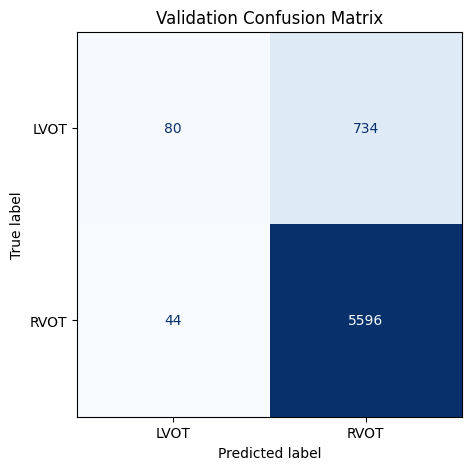

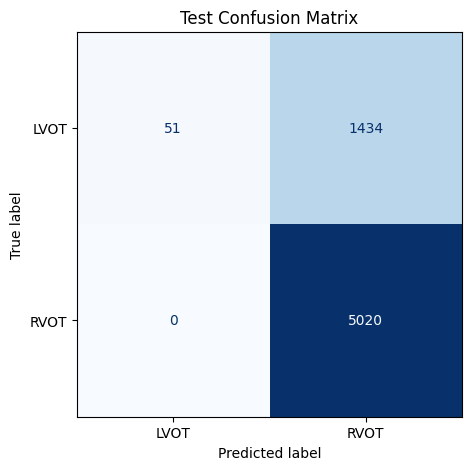

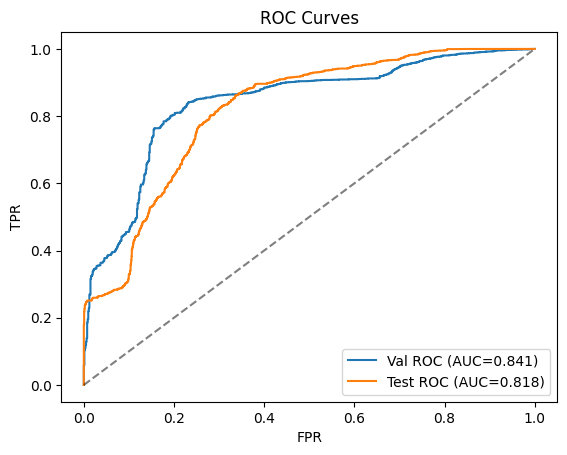

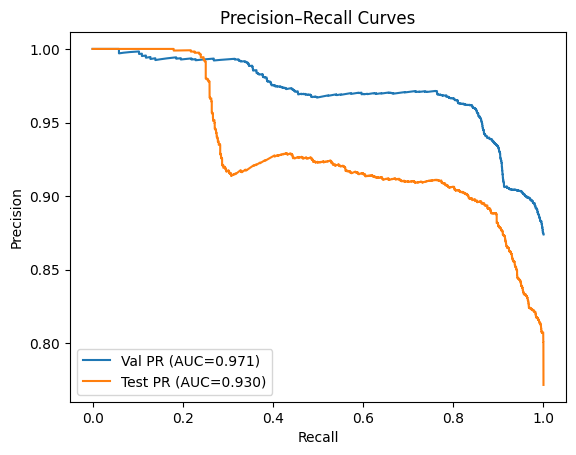

<Figure size 800x600 with 0 Axes>

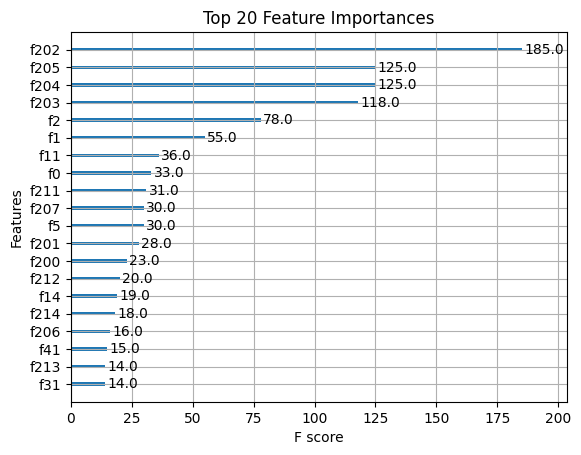

In [6]:
best_model = xgb.XGBClassifier()
best_model.load_model('outputs/xgb_macro_f1_best_model_B.bin')

evaluate_with_auto_threshold(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    calibrate=True,
    calibrator_method='sigmoid'
)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_B, y_train_B)
print(classification_report(y_test_B, lr.predict(X_test_B)))

              precision    recall  f1-score   support

        LVOT       0.36      0.64      0.46      1485
        RVOT       0.86      0.67      0.75      5020

    accuracy                           0.66      6505
   macro avg       0.61      0.65      0.61      6505
weighted avg       0.75      0.66      0.69      6505



/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
